# Has the Average Dave Score Drifted over time?

The goal of this analysis is to determine whether Dave's average pizza score has drifted over time. To accomplish this, I will measure his average score per year and compare the averages. I will then normalize for location. I collected every pizza score Dave has done since March 13th, 2013 via a Selenium script. 

In [13]:
#imports
import seaborn as sns
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Data

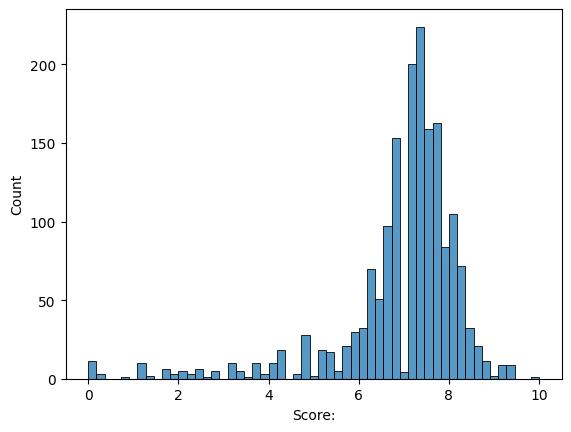

In [29]:
#Pull CSV 
reviews = pd.read_csv('scraped_data_may24.csv')
reviews['Date'] = pd.to_datetime(reviews['Date'])

score = reviews['Score:']
name = reviews['Name']
location = reviews['Location']
date = reviews['Date']


#Scores by year



sns.histplot(data=reviews, x=reviews['Score:'])

average = score.mean()

In [33]:
reviews.dtypes

reviews.resample('Score:', on='Date').mean()


ValueError: Invalid frequency: Score:, failed to parse with error message: ValueError('last element must be blank')